Since I have to wait so much for tensorflow to do its thing im reimplementing this in jax for speed

In [1]:
from multiprocessing import cpu_count
import os 
n_proc = cpu_count()

os.environ["XLA_FLAGS"] = (
    f"--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads={n_proc} inter_op_parallelism_threads={n_proc}"
)
os.environ["OPENBLAS_NUM_THREADS"] = f"{n_proc}"
os.environ["MKL_NUM_THREADS"] = f"{n_proc}"
os.environ["OMP_NUM_THREAD"] = f"{n_proc}"
os.environ["NPROC"] = f"{n_proc}"

In [2]:
import jax.numpy as jnp
import jax
from jax.scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import jax.random as jrand
import straxen
from dataclasses import dataclass
import optax
import os, sys
from tqdm import tqdm


2025-03-08 10:53:20,429 - admix - WARNING - Initializing utilix DB failed. You cannot do database operations


DB initialization failed


In [3]:
# Basic Layer Functions

def get_Radius(x, pmt_pos_top):
    return jnp.sqrt(jnp.sum((x[:,None,:] - pmt_pos_top[None,:,:])**2, axis=-1))

def I0_Layer(x, i0s):
    return x*i0s

def WallDist(x, pmt_pos_top, tpc_radius):
    #Euclidean norm
    pos_mag = jnp.sqrt( jnp.sum(x**2, axis=-1, keepdims=True) )
    scaling = tpc_radius/ jnp.maximum(pos_mag, 1e-7)
    projection = x * scaling

    event_wall_distance = jnp.repeat(jnp.abs(tpc_radius - pos_mag), 246, axis=1)[...,None]
    # shapes=[(32, 1, 32, 2), (1, 253, 2)]
    pmt_wall_distance = jnp.sqrt(jnp.sum((projection[:,None,:] - pmt_pos_top[None,:,:])**2, axis=-1, keepdims=True))
    # n, 246, 2
    return jnp.concatenate([pmt_wall_distance, event_wall_distance], axis=-1)

def WiresInLightCone(x, angle, pmt_pos, pmt_radius, h, H, wire_pitch):
    # Should compile this away 
    rot_matrix = jnp.array([
        [jnp.cos(angle), -jnp.sin(angle)],
        [jnp.sin(angle),  jnp.cos(angle)]
    ]).T
    pmt_rot = jnp.matmul(pmt_pos, rot_matrix)
    # 1, n_pmts
    pmt_min = (pmt_rot[:,0] - pmt_radius)[None,:]
    pmt_plus = (pmt_rot[:,0] + pmt_radius)[None, :]
    
    x_rot = jnp.matmul(x, rot_matrix)
    # n,n_pmts
    return jnp.abs( (h/(h+H)) * (pmt_min + pmt_plus - 2*x_rot[:,1,None]) ) / wire_pitch

def normalize(X):
    X = jnp.abs(X)
    return X / jnp.maximum(jnp.sum(X, axis=-1, keepdims=True), 1e-7)

# Loss Function 
p_dpe = 0.2
min_pe = 0

def common_std(mu, std):
    """Return equivalent standard deviation due to Poisson detection + DPE emission + SPE variation
    mu: Number of photons expected
    """ 
    npe_mean = mu * (1 + p_dpe)
    # Note variance from Poisson is mu
    # but n_pe ~ (1 + p_dpe) n_ph
    # By square-linearity of the variance, we must scale my (1 + p_dpe)**2
    return (mu * (1 + p_dpe)**2
            + mu * p_dpe * (1 - p_dpe)
            + (npe_mean**0.5 * std)**2)**0.5

def approx_pdf(x, mu, std):
    npe_mean = mu * (1 + p_dpe)
    return stats.norm.pdf(
        x,
        loc=npe_mean,
        scale=common_std(mu, std)
    ) * (1 - stats.poisson.pmf(0, mu=mu))

def approx_lr(x, mu, std):
    mu_hat = jnp.clip(x / (1 + p_dpe), 1, None) - 0.6
    tmp= -2 * (jnp.log(approx_pdf(x, mu,std))
                 - jnp.log(approx_pdf(x, mu_hat,std)))
    return tmp

def true_lr_scalar(x, mu, std, max_sigma = 4):
    """Do Log likelihood ratio"""
    # Result for x = 0 is trivial otherwise eval full
    def null_res(x, mu, std, max_sigma):
        return -2 * stats.poisson.logpmf(x, mu)
    def non_null(x, mu, std, max_sigma): 
        return -2 * (jnp.log(true_pdf(x, mu, std = std, max_sigma=max_sigma)) - jnp.log(true_pdf(mu, jnp.clip(mu / (1 + p_dpe), 1, None), std = std, max_sigma=max_sigma)))
    # We use cond for conditional evaluation and vmap to vectorize
    return jax.lax.cond(
        (x > min_pe) & (mu > min_pe),
        non_null,
        null_res,
        x, mu, std, max_sigma
    )
true_lr = jax.vmap(true_lr_scalar, in_axes=(0, 0, 0))

def truncnorm_pdf(x, mean, std, left_clip=min_pe):
    # Truncated normal dist
    return stats.truncnorm.pdf(
        x,
        (left_clip - mean)/std, float('inf'),
        loc=mean, scale=std)

def true_pdf(x, mu, std, max_sigma=4):
    """
    Probability density function for:
    - x: Expectation
    - mu : Observation 

    Computes number of Photoelectrons and photons without double photoelectron emission 

    Creates integer lists to compute likelihoods for each integer position within sigma for each

    Computes the truncated norm PDF for the observed signal vs each possible expected mean and standard deviation pair

    Does the same for Binomial for double photoelectron emission for difference photon to photelectron

    And for Poisson distribution of observed photons 

    Sums the entire thing after multiplication 

    FIXME: Jax cant handle dependetnt jnp.arange
    So instead of computing constant sigma = 4, we compute variable sigma that is always > 4 
    using x = 40 gives 58 and 67 max, using x=20 gives 34 and 39
    """
    # Full dist
    #n_pe_mle = jnp.clip(40, 0, None)
    #n_ph_mle = jnp.clip(40 / (1 + p_dpe), 0, None)
    n_ph = jnp.arange(1, 58).reshape(-1, 1)
    n_pe = jnp.arange(1, 67).reshape(1, -1)
    #n_ph = jnp.arange(1, n_ph_mle + max_sigma * n_ph_mle**0.5 + 2).reshape(-1, 1)
    #n_pe = jnp.arange(1, n_pe_mle + max_sigma * n_pe_mle**0.5 + 2).reshape(1, -1)
    
    a = truncnorm_pdf(x, mean=n_pe, std=std * n_pe**0.5)
    b = stats.binom.pmf(n_pe - n_ph, n_ph, p_dpe)
    c = stats.poisson.pmf(n_ph, mu)

    tmp = (a * b * c).sum()

    return tmp


def mixed_lr_scalar(x, mu, std):
    """Return -2 log likelihood ratio for seeing x PE when mu photons are expected in total
    x and mu should both be rank-1 tensors; the return value has the same dimensions.
    """
    # Use full likelihood for small x's
    # We don't want to use tf.where, since it evalutes both arguments everywhere
    # and only then does the selection.
    #if (x < 20) & (mu < 40) | (x < 40) & (mu < 20):
    #    return true_lr(x, mu, std)
    #else:
    #    return approx_lr(x, mu, std)
    tmp  = jax.lax.cond(
        ((x < 20) & (mu < 40)) | ((x < 40) & (mu < 20)),
        true_lr_scalar,
        approx_lr,
        x, mu, std
    )
    # Replace inf in case it happens - Mainly during training
    tmp = jnp.where(jnp.isinf(tmp), 1e3, tmp)
    return tmp
    
"""
Vectorize like this since for the different branches different size arrays will be created as intermediaries
"""
# So we can apply to n,
mixed_lr = jax.vmap(mixed_lr_scalar, in_axes=(0, 0, 0))
# So we can apply to n, m
mixed_lr2d = jax.vmap(mixed_lr, in_axes=(0, 0, 0))

In [4]:
### NN component functions

# Activation functions
def exponential(x):
    return jnp.exp(x)

def relu(x):
    return jnp.maximum(x, 0)

def tanh(x):
    return jnp.tanh(x)

# Initializer
def init_dense_params(rng, layer_sizes):
    keys = jax.random.split(rng, len(layer_sizes))
    return [(jax.random.normal(k, (layer_sizes[i], layer_sizes[i+1])), jax.random.normal(k, (layer_sizes[i+1],))) for i, k in enumerate(keys)]

# Dense Layers
def apply_dense(params, x):
    return jnp.dot(x, params["w"]) + params["b"]
def apply_dense_vmap(params, x):
    """We want to only operate on the last dimension"""
    return jax.vmap(jax.vmap(apply_dense, in_axes=(None, 0)), in_axes=(None, 0))(params, x)
def direct_detection_dense(params, x):
    x = tanh(apply_dense_vmap(params['layer_1'], x))
    x = exponential(apply_dense_vmap(params['layer_2'], x))
    return x
def wall_reflection_dense(params, x):
    x = tanh(apply_dense_vmap(params['layer_1'], x))
    x = exponential(apply_dense_vmap(params['layer_2'], x))
    return x

def predict(params, pos, patterns, misc, no_likelihood = False):
    # Get Direct Detection 
    pred = get_Radius(pos, misc.pmt_pos_top)
    #if jnp.isnan(pred).any(): 
    #    print(pred)
    #    raise ValueError("Radius")
    pred = direct_detection_dense(params['direct_detection'], pred)
    #if jnp.isnan(pred).any(): 
    ##    print(pred)
    ##    print(params['direct_detection'])
    #    raise ValueError("Pre Norm Direct")
    pred = normalize(pred[...,0,0])
    #if jnp.isnan(pred).any(): 
    #    print(pred)
    #    raise ValueError("Post Norm Direct")
    # Get Wall Reflection
    wall = WallDist(pos, misc.pmt_pos_top, misc.tpc_radius)
    wall = wall_reflection_dense(params['wall_reflection'], wall)
    #if jnp.isnan(wall).any(): 
    #    print(wall)
    #    raise ValueError("Pre Norm Wall")
    wall = normalize(wall[...,0])
    #if jnp.isnan(wall).any(): 
    #    print(wall)
    #    raise ValueError("Post Norm Wall")
    # Combine and remove singleton
    pred = I0_Layer((pred + params['wall_scale'] * wall), params['i0s'])
    #if jnp.isnan(pred).any(): 
    #    print(pred)
    #    raise ValueError("Pre Norm Combine")
    pred = normalize(pred)
    #if jnp.isnan(pred).any(): 
    #    print(pred)
    #    raise ValueError("Post Norm Combine")
    if no_likelihood:
        return pred
    # Do Loss
    #pred = pred * jnp.sum(patterns, axis=-1, keepdims=True)
    #chi2 = mixed_lr2d(pred, patterns, 
    #            jnp.broadcast_to(misc.std, (pred.shape[0], 246)))
    # Replace infinite values with large number
    #chi2 = jnp.nan_to_num(chi2, posinf=1e3, neginf=1e3)
    #if jnp.isnan(chi2).any(): raise ValueError("Post Loss")
    # Do temp debug MSE
    tmp = (patterns / patterns.sum(axis=-1, keepdims=True))
    chi2 = (100*(pred - tmp)/jnp.maximum(tmp, 1e-3))**2
    return chi2

def loss_function(params, x, y_true, misc):
    y_pred = predict(params, x, y_true, misc, no_likelihood=False)
    return jnp.mean(y_pred)


In [5]:
# Init Params
# Hardcoded fergot how I originally got this list - likely just checked for what is always 0
not_dead_pmts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252]


def init_dense_layer(key, input_dim, output_dim):
    w_key, b_key = jax.random.split(key)
    return {
        "w": jax.random.normal(w_key, (input_dim, output_dim)) * jnp.sqrt(2.0 / input_dim),  # He initialization
        "b": jnp.zeros((output_dim,))  # Zero bias initialization
    }

def init_params(rng_key,layer_sizes):
    keys = jax.random.split(rng_key, 4)  # One key per component
    params = {
        "direct_detection": {
            "layer_1": init_dense_layer(keys[0], input_dim=layer_sizes['direct_detection']['layer_1'], output_dim=layer_sizes['direct_detection']['layer_2']),
            "layer_2": init_dense_layer(keys[1], input_dim=layer_sizes['direct_detection']['layer_2'], output_dim=1),
        },
        "wall_reflection": {
            "layer_1": init_dense_layer(keys[2], input_dim=layer_sizes['wall_reflection']['layer_1'], output_dim=layer_sizes['wall_reflection']['layer_2']),
            "layer_2": init_dense_layer(keys[3], input_dim=layer_sizes['wall_reflection']['layer_2'], output_dim=1),
        },
        "i0s": jnp.ones((1,246,)),
        'wall_scale' : jnp.ones((1,))
    }
    
    return params

@dataclass
class TPCData:
    pmt_pos_top = jnp.array(straxen.pmt_positions()[straxen.pmt_positions()['array'] == 'top'].loc[:,['x','y']].to_numpy().astype('float32'))[not_dead_pmts,:]
    tpc_radius = 66.4
    h = 0.027 
    H = 68.58 / 10
    mesh_periodicity = 0.5
    pmt_radius = straxen.tpc_pmt_radius
    std = 0.5
    #TODO 
misc = TPCData()

In [6]:
def batch_generator(pos, patterns, batch_size, key, shuffle=True):
    """Creates a generator that yields batches of (x, y)."""
    num_samples = pos.shape[0]
    indices = jnp.arange(num_samples)

    if shuffle:
        key, subkey = jrand.split(key)
        indices = jrand.permutation(subkey, indices)

    for start_idx in range(0, num_samples, batch_size):
        end_idx = start_idx + batch_size
        batch_idx = indices[start_idx:end_idx]

        yield pos[batch_idx], patterns[batch_idx]

In [7]:
%pip install optax

/opt/XENONnT/anaconda/envs/XENONnT_el9.2024.10.4/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [63]:
def gen_train_funcs(optimizer, sharding=None, replicated_sharding=None):
    def train_step(params, opt_state, x, y_true):
        jax.debug.inspect_array_sharding(x, callback=print)
        jax.debug.inspect_array_sharding(y_true, callback=print)
        loss, grads = jax.value_and_grad(loss_function)(params, x, y_true, misc)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    
    train_step = jax.jit(train_step, inline = True, )
    
    def train_model(params, dataset, num_epochs=100, n_batches=None):
        opt_state = optimizer.init(params)
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            progress_bar = tqdm(dataset, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
            for batch_idx, (x_batch, y_batch) in enumerate(progress_bar, start=1): 
                #x_batch = jax.device_put(x_batch, sharding)
                #y_batch = jax.device_put(y_batch, sharding)
                #params = jax.device_put(params, replicated_sharding)
                params, opt_state, loss = train_step(params, opt_state, x_batch, y_batch)
                epoch_loss += loss
                if n_batches is not None:
                    progress_bar.set_postfix(loss=epoch_loss / batch_idx, batch=f"{batch_idx}/{n_batches}")

            progress_bar.set_postfix(loss=epoch_loss / n_batches) 

        return params
    return train_model, train_step

In [9]:
def get_data():
    # SR2 Processed data 
    tmp = []
    for i in os.listdir("/Code/processed_data/new_Kr"):
        tmp +=  [np.load(f"/Code/processed_data/new_Kr/{i}")['arr_0']]
    tmp = np.concatenate(tmp)
    return (jnp.array(np.column_stack([tmp['s2_x_cnf'], tmp['s2_y_cnf']]).astype('float32')), 
            jnp.array(tmp['s2_area_per_channel'][:,not_dead_pmts]).astype('float32'))

pos, patterns = get_data()

In [69]:
# Make sure its divisible
n_proc = 1
batch_size = 2**10 // n_proc * n_proc
key = jrand.PRNGKey(0)
generator_key, params_key = jax.random.split(key)


mesh = jax.sharding.Mesh(jax.devices()*n_proc, ('batch',))
# Split batch across all available CPU threads
batch_sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec('batch'))
# Replicate optimizer state and parameters (usually small enough)
replicated_sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec())

layer_sizes = { #TODO HArd code layer 1 to expectation
    'direct_detection': {
        'layer_1': 1, #Input 
        'layer_2': 256 #shutdowOutput and second out is 1
    },
    'wall_reflection': {
        'layer_1': 2,
        'layer_2': 256
    }
}
jax.config.update("jax_debug_nans", False)
params = init_params(params_key,layer_sizes)

learning_rate = 0.01
optimizer = optax.adam(learning_rate)
print("First")
train_model, train_step = gen_train_funcs(optimizer,sharding=batch_sharding, replicated_sharding=replicated_sharding) # Jit compilation doesnt like funcs as args
params = train_model(params, 
                     batch_generator(pos, patterns, batch_size, generator_key), 
                     num_epochs=2, 
                     n_batches = pos.shape[0]//batch_size+1)

learning_rate = 0.001
optimizer = optax.adam(learning_rate)
print("Second")
train_model, train_step = gen_train_funcs(optimizer)
params = train_model(params, 
                     batch_generator(pos, patterns, batch_size, generator_key), 
                     num_epochs=2, 
                     n_batches = pos.shape[0]//batch_size+1)


First


Epoch 1/2: 0it [00:00, ?it/s]

PositionalSharding([{CPU 0}], shape=(1,))
PositionalSharding([{CPU 0}], shape=(1,))


Epoch 1/2: 1755it [12:30,  2.35it/s, batch=1755/1756, loss=1774.7527]

PositionalSharding([{CPU 0}], shape=(1,))
PositionalSharding([{CPU 0}], shape=(1,))


Epoch 1/2: 1756it [12:31,  2.34it/s, batch=1756/1756, loss=1774.5237]
Epoch 2/2: 0it [00:00, ?it/s]


Second


Epoch 1/2: 0it [00:00, ?it/s]
Epoch 2/2: 0it [00:00, ?it/s]


In [75]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'ActualThesisWork'))
%load_ext autoreload
%autoreload 2
from functions import *

2025-03-08 17:50:29.252527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-08 17:50:29.252675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-08 17:50:29.314720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 17:50:30.205223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<Axes: xlabel='X position (cm)', ylabel='Y position (cm)'>

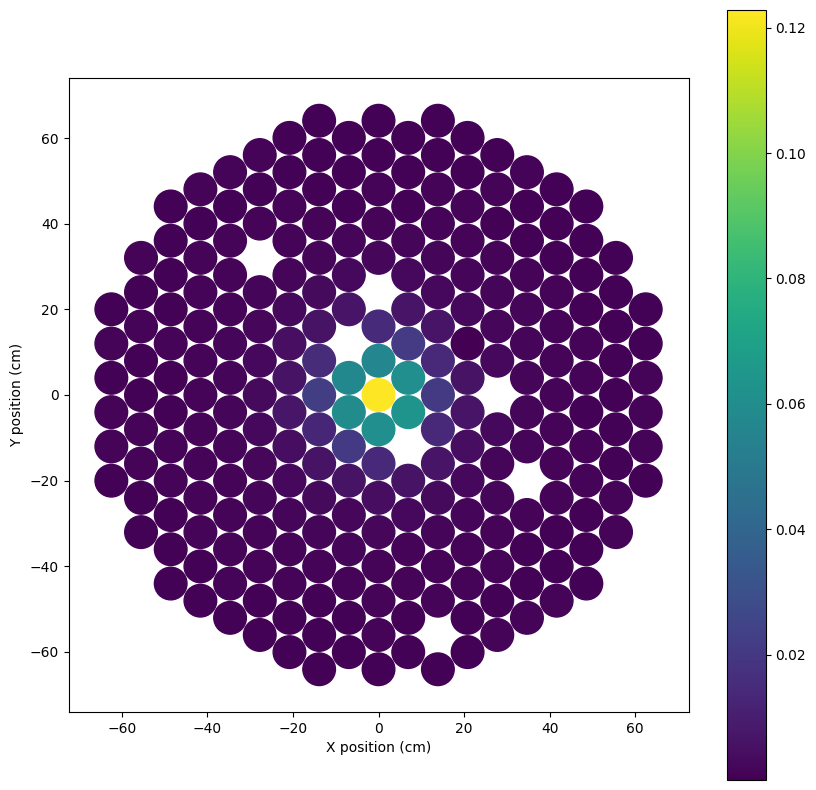

In [79]:
tmp = predict(params, pos=jnp.array([[0.,0]]), patterns=None, misc=misc, no_likelihood = True)
plot_pmt_response(jnp.array(straxen.pmt_positions()[straxen.pmt_positions()['array'] == 'top'].loc[:,['x','y']].to_numpy().astype('float32'))[not_dead_pmts,:], tmp[0])

In [71]:
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
print("Second")
train_model, train_step = gen_train_funcs(optimizer)
data_generator = batch_generator(pos, patterns, batch_size, generator_key)
params = train_model(params, data_generator, num_epochs=2, n_batches = pos.shape[0]//batch_size+1)


Second


Epoch 1/2: 0it [00:00, ?it/s]

PositionalSharding([{CPU 0}], shape=(1,))
PositionalSharding([{CPU 0}], shape=(1,))


Epoch 1/2: 779it [05:36,  2.32it/s, batch=779/1756, loss=1367.5933]


KeyboardInterrupt: 

In [387]:
mixed_lr_scalar(0, 1000,  0.5)

Array(10000000., dtype=float32, weak_type=True)

In [360]:
approx_lr(1, 20,  0.5)

Array(15.258023, dtype=float32, weak_type=True)

In [361]:
jnp.clip(1000 / (1 + p_dpe), 1, None)

Array(833.3333, dtype=float32, weak_type=True)

In [391]:
x, mu, std, max_sigma = 20,20/1.2, 0.5, 4
n_ph = jnp.arange(1, 58).reshape(-1, 1)
n_pe = jnp.arange(1, 67).reshape(1, -1)
#n_ph = jnp.arange(1, n_ph_mle + max_sigma * n_ph_mle**0.5 + 2).reshape(-1, 1)
#n_pe = jnp.arange(1, n_pe_mle + max_sigma * n_pe_mle**0.5 + 2).reshape(1, -1)

a = truncnorm_pdf(x, mean=n_pe, std=std * n_pe**0.5)
b = stats.binom.pmf(n_pe - n_ph, n_ph, p_dpe)
c = stats.poisson.pmf(n_ph, mu)


In [394]:
(a*b*c).sum()

Array(0.07038108, dtype=float32)

In [392]:
def non_null(x, mu, std, max_sigma): 
    print(true_pdf(mu, jnp.clip(mu / (1 + p_dpe), 1, None), std = std, max_sigma=max_sigma))
    print(true_pdf(x, mu, std = std, max_sigma=max_sigma))
    return -2 * (jnp.log(true_pdf(x, mu, std = std, max_sigma=max_sigma)) - jnp.log(true_pdf(mu, jnp.clip(mu / (1 + p_dpe), 1, None), std = std, max_sigma=max_sigma)))
non_null(1, 20, 0.5, 4)    

0.070381075
1.8520231e-07


Array(25.695972, dtype=float32)

In [381]:
true_lr_scalar(1e-7, 100000,  0.5)


FloatingPointError: invalid value (nan) encountered in jit(cond). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

# Encoder Model

This is surprisingly easy to implement

In [ ]:
# X is now a linear index 
def embedding_loss(params, pos_params, x, y_true, misc):
    return loss_function(params, pos_params[x], y_true, misc)
def embed_pos(pos):
    return {"positions": pos}